In [23]:
import numpy, math, time
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv, spsolve, spsolve_triangular

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [24]:
def generate_A(h):
    # Generating matrix A as sparse COO matrix
    b = numpy.zeros((n+2)*(m+2))
    
    row = []
    col = []
    data = []

    start = m+3
    while start <= n*(m+2)+1: 
        for j in range(start, start+m):
            row.append(j)
            col.append(j)
            data.append(4)
            row.extend([j]*4)
            col.extend([j-1, j+1, j+m+2, j-m-2])
            data.extend([-1]*4)
        start += m+2

    b[list(range(1, m+1))] = T_south
    b[list(range(0, (n+1)*(m+2)+1, m+2))] = T_west
    b[list(range((n+1)*(m+2)+1, (n+2)*(m+2)))] = T_north
    b[list(range(m+1, (n+2)*(m+2), m+2))] = T_east
    row.extend(numpy.nonzero(b)[0])
    col.extend(numpy.nonzero(b)[0])
    data = data + [1]*len(numpy.nonzero(b)[0])

    row = numpy.asarray(row)
    col = numpy.asarray(col)
    data = numpy.asarray(data)
    print(len(row))
    A = sp.coo_matrix((data, (row, col)), shape=((n+2)*(m+2), (n+2)*(m+2)))
    return A, b

In [25]:
def plot_sparsity(A):
    # Sparsity plot of A
    plt.spy(A)
    plt.show()

In [27]:
def jacobi(A, b, x_0, iters=math.inf, tol=0.01):
    #Jacobi iterative method
    residuals = []
    err = numpy.linalg.norm(A.dot(x_0) - b)
    residuals.append(err)
    
    x = x_0
    d = A.diagonal()
    dinv = 1.0/d
    its = 0
    while err > tol and its < iters:
        p = b - A.dot(x) + numpy.multiply(d, x)
        x_new = numpy.multiply(dinv, p)
        err = numpy.linalg.norm(A.dot(x_new) - b)
        residuals.append(err)
        x = x_new
        its += 1

    return its+1, residuals, x
    plt.plot(range(iters+1), numpy.log(numpy.array(residuals)))
    plt.ylabel("Log residual")
    plt.xlabel("Iteration number")
    plt.show()

In [28]:
def gs(A, b, x_0, iters=math.inf, tol=0.01):
    #Gauss Seidel iterations
    residuals = []
    err = numpy.linalg.norm(A.dot(x_0) - b)
    residuals.append(err)
    
    x = x_0
    L = sp.tril(A).tocsc()
    U = sp.triu(A, k=1)
    Linv = inv(L)
    its = 0
    while err > tol and its < iters:
        #x_new = spsolve_triangular(L, b - U.dot(x))
        x_new = Linv.dot(b - U.dot(x))
        err = numpy.linalg.norm(A.dot(x_new) - b)
        residuals.append(err)
        x = x_new
        its += 1

    return its+1, residuals, x
    plt.plot(range(iters+1), numpy.log(numpy.array(residuals)))
    plt.ylabel("Log residual")
    plt.xlabel("Iteration number")
    plt.savefig('residual_gs_h' + str(h) + '.png', bbox_inches='tight')

In [29]:
h = 0.1
m = (int)(length/h - 1)
n = (int)(breadth/h - 1)
A, b = generate_A(h)

x0 = numpy.zeros_like(b)

%lprun -f gs gs(A, b, x0)

29525
*** KeyboardInterrupt exception caught in code being profiled.

In [30]:
def direct(A, b):
    # Direct solve
    x = spsolve(A, b)
    return x

In [31]:
# Room specs
length = 10
breadth = 6
T_west = 330
T_east = 320
T_south = 310
T_north = 300

29525


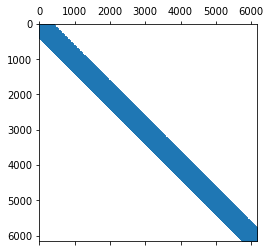

In [33]:
# Plotting sparsity for mesh size h = 1
h=0.1
m = (int)(length/h - 1)
n = (int)(breadth/h - 1)
A, b = generate_A(h)
plot_sparsity(A)   

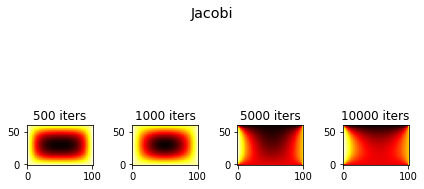

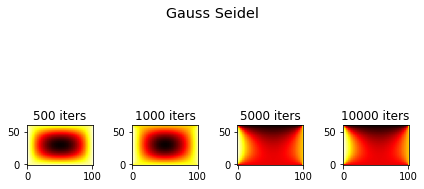

In [13]:
#Temperature distribution as a function of number of iterations for Jacobi and GS

h = 0.1
m = (int)(length/h - 1)
n = (int)(breadth/h - 1)
A, b = generate_A(h)

x0 = numpy.zeros_like(b)
iters = [500, 1000, 5000, 10000]

fig = plt.figure(1)
st = fig.suptitle("Jacobi", fontsize="x-large")
for i, it in enumerate(iters):
    _, _, x = jacobi(A, b, x0, iters=it)
    ax = fig.add_subplot(1, 4, i+1)
    u_mat = numpy.zeros((n+2, m+2))
    start = 0
    for row in range(n+2):
        u_mat[row, :] = x[start:start+m+2]
        start += m+2
    ax.imshow(u_mat, cmap='hot', interpolation='nearest', origin='lower')
    ax.set_title(str(it) + " iters")

fig.tight_layout()


fig = plt.figure(2)
st = fig.suptitle("Gauss Seidel", fontsize="x-large")
for i, it in enumerate(iters):
    _, _, x = gs(A, b, x0, iters=it)
    ax = fig.add_subplot(1, 4, i+1)
    u_mat = numpy.zeros((n+2, m+2))
    start = 0
    for row in range(n+2):
        u_mat[row, :] = x[start:start+m+2]
        start += m+2
    ax.imshow(u_mat, cmap='hot', interpolation='nearest', origin='lower')
    ax.set_title(str(it) + " iters")

fig.tight_layout()
plt.show()

We can see that Gauss-Seidel iterative method converges much faster, since the norm of the residual vanishes within fewer number of iterations. This is clear from the heat maps above - the distribution obtained using GS is identical for 5000 and 10000 iterations.

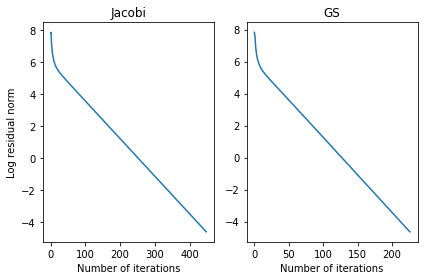

In [9]:
#Comparing number of iterations needed for convergence for Jacobi vs GS
h = 0.5
m = (int)(length/h - 1)
n = (int)(breadth/h - 1)
A, b = generate_A(h)

x0 = numpy.zeros_like(b)

fig = plt.figure()
plt.subplot(121)
its, resid, x = jacobi(A, b, x0)
plt.plot(range(its), numpy.log(numpy.array(resid)))
plt.ylabel("Log residual norm")
plt.xlabel("Number of iterations")
plt.title("Jacobi")

plt.subplot(122)
its, resid, x = gs(A, b, x0)
plt.plot(range(its), numpy.log(numpy.array(resid)))
plt.xlabel("Number of iterations")
plt.title("GS")

plt.tight_layout()
plt.show()

From the above plots, it is clear the GS converges much faster than Jacobi

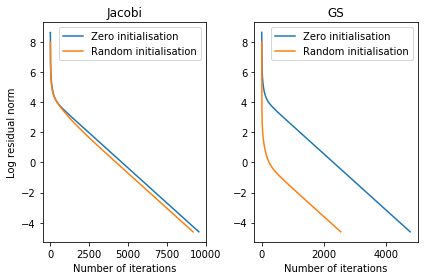

In [16]:
#Comparing effect of different initialisations on rate of decrease of residual norm
h = 0.1
m = (int)(length/h - 1)
n = (int)(breadth/h - 1)
A, b = generate_A(h)

x_0 = []
inits = []
x_0_len = b.shape[0]

#Zero init
x_0.append(numpy.zeros(x_0_len))
inits.append("Zero initialisation")
# Random init between 300K and 330 K
x_0.append(30*numpy.random.random_sample(x_0_len) + 300)
inits.append("Random initialisation")


#Running Jacobi and GS with tol = 0.01 and number of iters = 100
fig = plt.figure()

plt.subplot(121)
for i, x0 in enumerate(x_0):
    its, resid, x = jacobi(A, b, x0)
    plt.plot(range(its), numpy.log(numpy.array(resid)), label=inits[i])
plt.legend()
plt.ylabel("Log residual norm")
plt.xlabel("Number of iterations")
plt.title("Jacobi")

plt.subplot(122)
for i, x0 in enumerate(x_0):
    its, resid, x = gs(A, b, x0)
    plt.plot(range(its), numpy.log(numpy.array(resid)), label=inits[i])
plt.legend()
plt.xlabel("Number of iterations")
plt.title("GS")

plt.tight_layout()
plt.show()

From the above plot for convergence in GS, we see that random initialisation between minimum and maximum temperatures is a much better initialisation than a zero vector. The two initialisations are comparable for Jacobi method. For further analysis, the random initialisation of $x_0$ will be used.

Time taken by Jacobi = 0.11267209053039551
Time taken by GS = 5.844159126281738
Temperature in the centre of the room using Jacobi solver = 308.73386066116905
Temperature in the centre of the room using GS solver = 308.75563442896754
Temperature in the centre of the room using Direct solver = 308.7331408140783


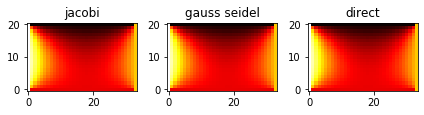

In [11]:
#Heatmaps of temperature distribution for Jacobi, GS and Direct solver
h = 0.3
m = (int)(length/h - 1)
n = (int)(breadth/h - 1)
A, b = generate_A(h)

# Random init between 300K and 330 K
x_0 = 30*numpy.random.random_sample(b.shape[0]) + 300

start = time.time()
_, _, x_jacobi = jacobi(A, b, x_0)
print("Time taken by Jacobi = " + str(time.time() - start))
start = time.time()
_, _, x_gs = gs(A, b, x_0)
print("Time taken by GS = " + str(time.time() - start))
x_direct = direct(A, b)


mid = (int)(x_jacobi.shape[0]/2)
print("Temperature in the centre of the room using Jacobi solver = " + str(x_jacobi[mid]))
print("Temperature in the centre of the room using GS solver = " + str(x_gs[mid]))
print("Temperature in the centre of the room using Direct solver = " + str(x_direct[mid]))
x = [x_jacobi, x_gs, x_direct]
title = ["jacobi", "gauss seidel", "direct"]
fig = plt.figure()
for i in range(3):
    u_mat = numpy.zeros((n+2, m+2))
    start = 0
    for row in range(n+2):
        u_mat[row, :] = x[i][start:start+m+2]
        start += m+2
    plt.subplot(1, 3, i+1)
    plt.imshow(u_mat, cmap='hot', interpolation='nearest', origin='lower')
    plt.title(title[i])

plt.tight_layout()
plt.show()